Recording... Press Enter to stop.


Recording stopped.

 Playing Original Noisy Audio...


Denoised audio saved as denoised_output.wav


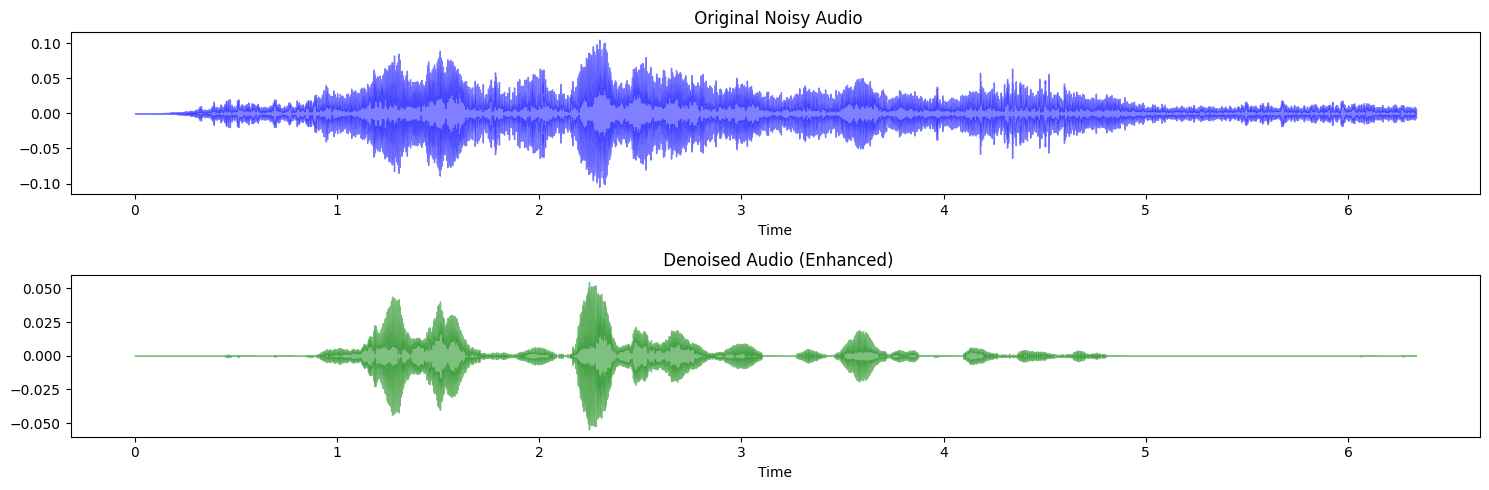


 Playing Denoised Audio...


In [14]:
import numpy as np
import sounddevice as sd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import scipy.signal
from scipy.io.wavfile import write
import noisereduce as nr
import IPython.display as ipd
import threading

sample_rate = 44100  
mic_index = None  
global recording
recording = True  

def record_audio_realtime(sample_rate, mic_index=None):
    global recording
    print("Recording... Press Enter to stop.")
    
    audio_data = np.array([], dtype=np.float32)

    def callback(indata, frames, time, status):
        nonlocal audio_data
        if status:
            print(status)
        audio_data = np.append(audio_data, indata[:, 0]) 

    with sd.InputStream(samplerate=sample_rate, channels=1, dtype=np.float32, device=mic_index, callback=callback):
        input()
        recording = False
        print("Recording stopped.")

    return audio_data

def spectral_gating(audio, sample_rate):
    return nr.reduce_noise(y=audio, sr=sample_rate, stationary=False)

def wavelet_denoising(audio):
    import pywt
    coeffs = pywt.wavedec(audio, 'db8', level=6)
    threshold = np.median(np.abs(coeffs[-1])) / 0.675
    coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
    return pywt.waverec(coeffs, 'db8')

def adaptive_threshold(audio):
    threshold = np.mean(np.abs(audio)) * 0.5
    return np.where(np.abs(audio) > threshold, audio, 0)

def bandpass_filter(audio, lowcut=300, highcut=3400, sample_rate=44100, order=6):
    nyquist = 0.5 * sample_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = scipy.signal.butter(order, [low, high], btype='band')
    return scipy.signal.lfilter(b, a, audio)

def apply_advanced_noise_reduction(audio, sample_rate):
    step1 = spectral_gating(audio, sample_rate)  
    step2 = wavelet_denoising(step1)             
    step3 = adaptive_threshold(step2)            
    step4 = bandpass_filter(step3)               
    return step4

def plot_waveform(original, cleaned, sample_rate):
    plt.figure(figsize=(15, 5))
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(original, sr=sample_rate, alpha=0.5, color='blue')
    plt.title(" Original Noisy Audio")

    plt.subplot(2, 1, 2)
    librosa.display.waveshow(cleaned, sr=sample_rate, alpha=0.5, color='green')
    plt.title(" Denoised Audio (Enhanced)")
    plt.tight_layout()
    plt.show()

noisy_audio = record_audio_realtime(sample_rate, mic_index)

print("\n Playing Original Noisy Audio...")
ipd.display(ipd.Audio(data=noisy_audio, rate=sample_rate))

cleaned_audio = apply_advanced_noise_reduction(noisy_audio, sample_rate)

output_path = "denoised_output.wav"
write(output_path, sample_rate, (cleaned_audio * 32767).astype(np.int16))
print(f"Denoised audio saved as {output_path}")

plot_waveform(noisy_audio, cleaned_audio, sample_rate)

print("\n Playing Denoised Audio...")
ipd.display(ipd.Audio(data=cleaned_audio, rate=sample_rate))